<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#aim-&amp;-purpose" data-toc-modified-id="aim-&amp;-purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>aim &amp; purpose</a></span></li><li><span><a href="#CPB-system" data-toc-modified-id="CPB-system-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CPB system</a></span></li><li><span><a href="#parameters" data-toc-modified-id="parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>parameters</a></span></li><li><span><a href="#Numerical-system-solve" data-toc-modified-id="Numerical-system-solve-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Numerical system solve</a></span><ul class="toc-item"><li><span><a href="#no-carbon-removal" data-toc-modified-id="no-carbon-removal-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>no carbon removal</a></span></li><li><span><a href="#with-carbon-removal" data-toc-modified-id="with-carbon-removal-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>with carbon removal</a></span></li></ul></li><li><span><a href="#Analytical-system-solve" data-toc-modified-id="Analytical-system-solve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analytical system solve</a></span></li></ul></div>

# aim & purpose

1. analytically and numerically solve the eco-cell carbon system
0. substitute in parameters and solve system
0. test for stability of system
0. parameter effect on carbon pool in each players
0. set of parameters max all three players

In [1]:
using PyCall, DataFrames, SymPy, Plots, Random
mt = pyimport("math")
sc = pyimport("scipy")
cst = pyimport("scipy.constants")
itg = pyimport("scipy.integrate")
sympy.init_printing() ## use other py3 function not implemented in native Julia-lang, http://mth229.github.io/symbolic.html
println()

# CPB system
\begin{equation*}\left\{\begin{array}{rl}
C'(t) &= (1-\varepsilon_P)\varepsilon_{PR}g_PP +a_PP^2 +g_BCB(e_{BR}(1-e_B)-1) +m_BB\\
P'(t) &= g_P\varepsilon_{PR}\varepsilon_PP -a_PP^2\\
B'(t) &= g_B\varepsilon_{BR}\varepsilon_{B}CB -m_BB
\end{array}\right.\end{equation*}

In [2]:
## env set-up
@vars C P B
x, e_PR,e_P,g_P,a_P, e_BR,e_B,g_B,m_B = symbols("x e_PR e_P g_P a_P e_BR e_B g_B m_B",positive=true)

## equations
dC = g_P*e_PR*(1-e_P)*P +a_P*P^2 +g_B*(e_BR*(1-e_B)-1)*C*B +m_B*B
dP = g_P*e_PR*e_P*P -a_P*P^2
dB = g_B*e_BR*e_B*C*B -m_B*B
dCrm = g_P*e_PR*(1-e_P)*P +a_P*P^2 +g_B*(e_BR*(1-e_B)-1)*C*B +m_B*B -x*C

                                              2                           
B⋅C⋅g_B⋅(e_BR⋅(1 - e_B) - 1) + B⋅m_B - C⋅x + P ⋅a_P + P⋅e_PR⋅g_P⋅(1 - e_P)

In [3]:
function ebc7(Den,t,x, g_P,e_PR,e_P,a_P, g_B,e_BR,e_B,m_B)
    
    ## variable sorting
    C = Den[:1]
    P = Den[:2]
    B = Den[:3]
    
    ## rate calculation
    dC = g_P*e_PR*(1-e_P)*P +a_P*P^2 +g_B*(e_BR*(1-e_B)-1)*C*B +m_B*B -x*C
    dP = g_P*e_PR*e_P*P -a_P*P^2
    dB = g_B*e_BR*e_B*C*B -m_B*B
    
    ## logic check
    if C<=0; dC=0;end
    if P<=0; dP=0;end
    if B<=0; dB=0;end
    
    return(sc.array([dC,dP,dB]))
    
end

ebc7 (generic function with 1 method)

# parameters

parameters | unit | meaning
--- | --- | ---
$x$ | $t^{-1}$ | rate of carbon removal from the system
$e_{PR}$ | no | fraction of phytocell non-respired carbon
$e_P$ | no | fraction of carbon incorporated into phytocell biomass
$g_P$ | $t^{-1}$ | phytocell growth rate
$a_P$ | $m^3gC^{-1}t^{-1}$ | intraspecific interference rate per density of phytocell carbon
$e_{BR}$ | no | fraction of microbial detritivore non-respired carbon
$e_B$ | no | fraction of carbon incorporated into microbial detritivore biomass
$g_B$ | $t^{-1}$ | microbial detritivore growth rate
$m_B$ | $t^{-1}$ | microbial detritivore death rate

In [4]:
## default settings
tStp = 20
t = sc.linspace(0, 1000, tStp) # sample time series
ini = [1 1 1] # gC/m3 C, P, B

## parameters (day^{-1})
x = 0 # larger value, lower eqm org-B pool
e_PR = .563 # larger value, increase in org-C < photocell < detritivore
e_P = .63 # larger value, increase in org-C < photocell < detritivore
g_P = .89 # larger value, larger eqm position of C-pools and differences between C-pools eqm values
a_P = .3 # opposite to the g_P effect
e_BR = .6 # larger value, lower org-C and higher detritivore
e_B = .55 # larger value, smaller detritivore and larger org-C
g_B = .8 # larger value, lower eqm org-C pool
m_B = .1 # smaller value, larger differences between C-pools eqm values; larger effect on detritivore

println()

# Numerical system solve
## no carbon removal

In [5]:
ss = solve([Eq(dC,0),Eq(dP,0),Eq(dB,0)],[C,P,B])
ss

1-element Array{Tuple{Sym,Sym,Sym},1}:
 (m_B/(e_B*e_BR*g_B), e_P*e_PR*g_P/a_P, -e_B*e_BR*e_P*e_PR^2*g_P^2/(a_P*m_B*(e_BR - 1)))

In [6]:
[ss[1][1],ss[1][2],ss[1][3]]

3-element Array{Sym,1}:
                              m_B/(e_B*e_BR*g_B)
                                e_P*e_PR*g_P/a_P
 -e_B*e_BR*e_P*e_PR^2*g_P^2/(a_P*m_B*(e_BR - 1))

In [7]:
[m_B/(e_B*e_BR*g_B), e_P*e_PR*g_P/a_P, -e_B*e_BR*e_P*e_PR^2*g_P^2/(a_P*m_B*(e_BR-1))]

3-element Array{Float64,1}:
 0.3787878787878788
 1.052247          
 4.349807585392499 

## with carbon removal

In [8]:
ss0 = solve([Eq(dCrm,0),Eq(dP,0),Eq(dB,0)],[C,P,B])
ss0

4-element Array{Tuple{Sym,Sym,Sym},1}:
 (0, 0, 0)                                                                                                           
 (m_B/(e_B*e_BR*g_B), 0, x/(e_BR*g_B - g_B))                                                                         
 (m_B/(e_B*e_BR*g_B), e_P*e_PR*g_P/a_P, (a_P*m_B*x - e_B*e_BR*e_P*e_PR^2*g_B*g_P^2)/(a_P*e_BR*g_B*m_B - a_P*g_B*m_B))
 (e_P*e_PR^2*g_P^2/(a_P*x), e_P*e_PR*g_P/a_P, 0)                                                                     

In [9]:
[ss0[3][1],ss0[3][2],ss0[3][3]]

3-element Array{Sym,1}:
                                                           m_B/(e_B*e_BR*g_B)
                                                             e_P*e_PR*g_P/a_P
 (a_P*m_B*x - e_B*e_BR*e_P*e_PR^2*g_B*g_P^2)/(a_P*e_BR*g_B*m_B - a_P*g_B*m_B)

# Analytical system solve

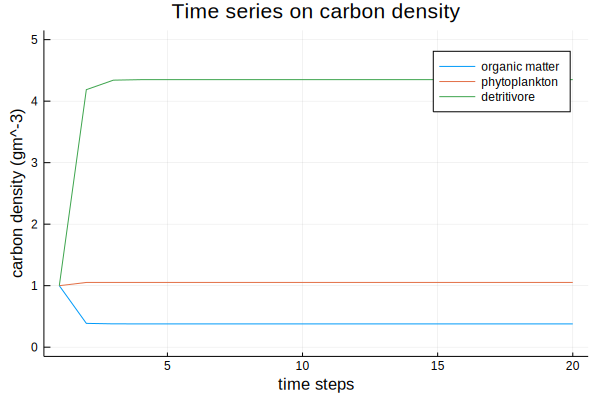

In [10]:
## model testing
pops = sc.array([ini[1],ini[2],ini[3]])

pops, infodict = itg.odeint(ebc7, pops, t, full_output=true, args=(x, g_P,e_PR,e_P,a_P, g_B,e_BR,e_B,m_B))
plot(pops, xlabel="time steps", ylabel="carbon density (gm^-3)", title="Time series on carbon density", lab=["organic matter" "phytoplankton" "detritivore"], ylim=[0,5])

┌ Info: Saved animation to 
│   fn = /home/xxxxxx/Project/sandbox/gif/randStart.gif
└ @ Plots /home/xxxxxx/.julia/packages/Plots/XpHkc/src/animation.jl:98


Plots.AnimatedGif("/home/xxxxxx/Project/sandbox/gif/randStart.gif")
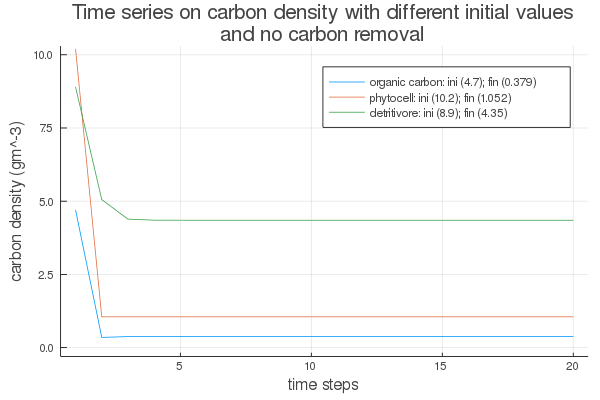

In [11]:
aa = @animate for i in 1:100
    pops = abs.(rand(Int8,3)/10)
    pops, infodict = itg.odeint(ebc7, pops, t, full_output=true, args=(x, g_P,e_PR,e_P,a_P, g_B,e_BR,e_B,m_B))
    plot(pops, xlabel="time steps", ylabel="carbon density (gm^-3)", title="Time series on carbon density with different initial values\nand no carbon removal",
        lab=["organic carbon: ini ("*string(round(pops[1,1]; digits=3))*"); fin ("*string(round(pops[tStp,1]; digits=3))*")" "phytocell: ini ("*string(round(pops[1,2]; digits=3))*"); fin ("*string(round(pops[tStp,2]; digits=3))*")" "detritivore: ini ("*string(round(pops[1,3]; digits=3))*"); fin ("*string(round(pops[tStp,3]; digits=3))*")"
            ], ylim=[0,10])
end
gif(aa, "gif/randStart.gif", fps=10)

┌ Info: Saved animation to 
│   fn = /home/xxxxxx/Project/sandbox/gif/rmC.gif
└ @ Plots /home/xxxxxx/.julia/packages/Plots/XpHkc/src/animation.jl:98


Plots.AnimatedGif("/home/xxxxxx/Project/sandbox/gif/rmC.gif")
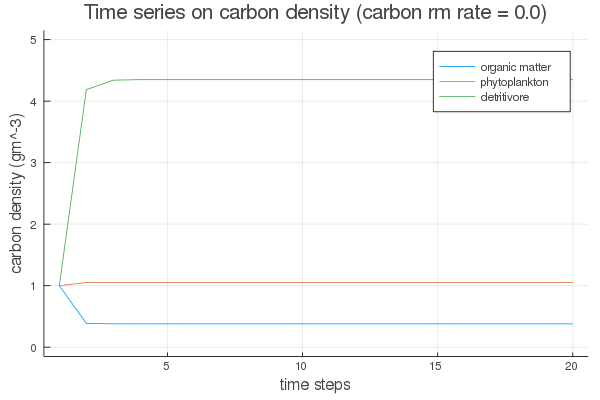

In [12]:
aa = @animate for i in 0:100
    pops = sc.array([ini[1],ini[2],ini[3]])
    test = i/100
    pops, infodict = itg.odeint(ebc7, pops, t, full_output=true, args=(test, g_P,e_PR,e_P,a_P, g_B,e_BR,e_B,m_B))
    plot(pops, xlabel="time steps", ylabel="carbon density (gm^-3)", title="Time series on carbon density (carbon rm rate = "*string(test)*")", lab=["organic matter" "phytoplankton" "detritivore"], ylim=[0,5])
end
gif(aa, "gif/rmC.gif", fps=20)